In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy

import math
import torch
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, ReLU
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import torch
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Inputs

In [2]:
#shape (Num, Channels, Timesteps)
Input_path = '/kaggle/input/active-learning-subset/tar_image_subset.npy' 
#shape (Num)
Labels_path = '/kaggle/input/active-learning-subset/label_target_subset.npy'

test_size = 0.2

"""
----------------------------------------------------------------------------------------
Loss Function selection
Currently available:
"ce = cross entropy loss","ls = LabelSmoothingCrossEntropyLoss"
"""
loss_mode = "ce"

"""
---------------------------------------------------------------------------------------------
Active Learning Method(s) to use
Currently available:
"random", "entropy", "margin", "least_confident", "diversity", "entropy_diversity", "density"
"""
strategies = [ 'margin', 'least_count']

"""
----------------------------------------------------------------------------------------
Shape(s) of data to test on:
(Initial samples, Iterations of AL loop, Query Sample Size)
"""
data = [(100,5,10), (300,5,10)]

# Data Loader

In [3]:
X = np.load(Input_path) 
y = np.load(Labels_path)

X_pool, X_val, y_pool, y_val = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val  shape: {y_val.shape}")


X shape: (20000, 6, 28)
y shape: (20000,)
X_val shape: (4000, 6, 28)
y_val  shape: (4000,)


In [4]:
y_sample = y
X_sample = X

# Checking Label distribution
label_counts = Counter(y_sample)
df_labels = pd.DataFrame.from_dict(label_counts, orient='index').sort_index()
df_labels.columns = ['count']
df_labels['percent'] = 100 * df_labels['count'] / len(y_sample)
print("\nLabel distribution:")
print(df_labels)

# Checking normalisation
channel_variance = np.var(X_sample, axis=2).mean(axis=0)
channel_mean = X_sample.mean(axis=(0, 2))
channel_std = X_sample.std(axis=(0, 2))
df_stats = pd.DataFrame({
    'channel': range(6),
    'mean': channel_mean,
    'std_dev': channel_std,
    'variance': channel_variance
})
print("\nMean, Std Dev and Variance per Channel:")
print(df_stats)


Label distribution:
   count  percent
0   9081   45.405
1   2603   13.015
2   8316   41.580

Mean, Std Dev and Variance per Channel:
   channel      mean   std_dev  variance
0        0  0.004546  0.999189  0.730689
1        1  0.004955  0.999538  0.721030
2        2  0.003958  1.000457  0.755685
3        3  0.001807  1.000751  0.783507
4        4  0.001153  1.000271  0.634434
5        5  0.001723  1.000909  0.731176


In [5]:
# Total number of samples
total_samples = sum(label_counts.values())

# Number of classes
num_classes = max(label_counts.keys()) + 1  # assuming labels are integers from 0-n

# Computing weights for each class as inverse frequency
class_weights = []
for i in range(num_classes):
    count = label_counts.get(i, 0)
    if count == 0:
        class_weights.append(1e-6)  # ignoring non-present classes
    else:
        class_weights.append(total_samples / (num_classes * count))

print(class_weights)
# Convert to torch tensor for CE loss function
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


[0.7341335388907242, 2.5611473940325267, 0.801667468334135]


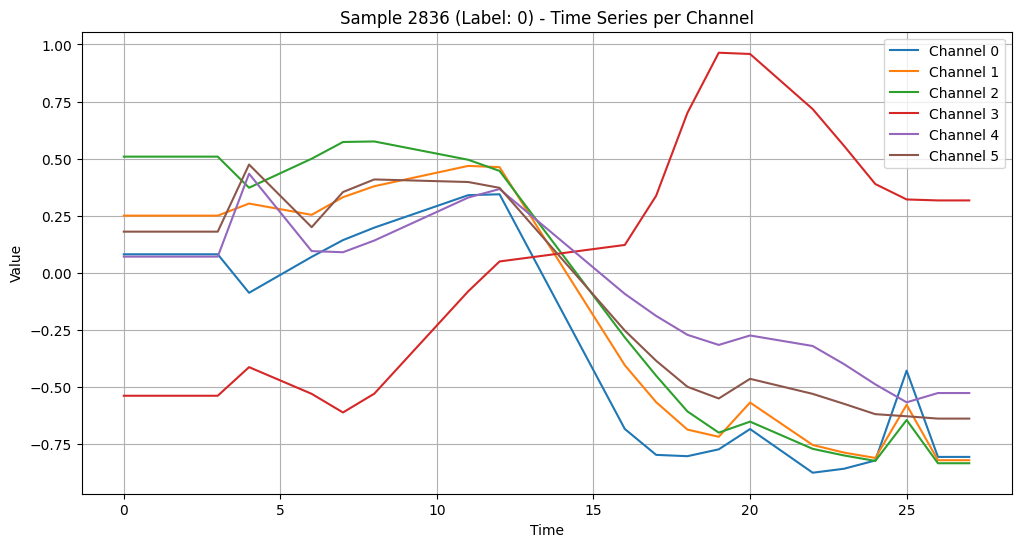

In [6]:
#viewing sample X image channel values per timestep

i = np.random.randint(0, len(X))
sample = X[i]  # Shape: (6, T)

plt.figure(figsize=(12, 6))
for c in range(6):
    plt.plot(sample[c], label=f'Channel {c}')
plt.title(f"Sample {i} (Label: {y[i]}) - Time Series per Channel")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Dataloader

In [7]:
class Dataset():
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, index):
        return {
            "x": self.X[index],  # shape: [C, T]
            "y": self.y[index]
        }

    def __len__(self):
        return len(self.X)

# Loss Functions

In [8]:

class Loss:
    def __init__(self, weight=None, ignore_index=-100, device=None, smoothing=0.1):
        self.weight = weight
        self.ignore_index = ignore_index
        self.device = device
        self.smoothing = smoothing
        self.criterion = None
        self.loss_func = None

    def build(self, mode='ce'):
        """
        Available modes: 'ce', 'ls'
        """
        if mode == 'ce':
            self.criterion = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index)
            self.loss_func = self.cross_entropy_loss

        elif mode == 'ls':
            self.loss_func = self.label_smoothing_loss

        else:
            raise NotImplementedError(f"Loss mode '{mode}' is not implemented.")

        if self.device is not None and self.criterion is not None:
            self.criterion = self.criterion.to(self.device)

        return self.loss_func

    def cross_entropy_loss(self, logits, targets):
        return self.criterion(logits, targets)

    def label_smoothing_loss(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=-1)
        
        valid = targets != self.ignore_index
        log_probs = log_probs[valid]
        targets = targets[valid]
        
        nll_loss = -log_probs.gather(dim=-1, index=targets.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
    
        if self.weight is not None:
            weight = self.weight.to(logits.device)
            loss = loss * weight[targets]
    
        return loss.mean()


# Model

In [9]:
################ CNN Backbone 
def conv_block(in_channels: int, out_channels: int, dropout=0.3) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5, padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(dropout),
    )

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

 
################ Fully connected network
class FC(nn.Module):
    def __init__(self, input_dim):
        super(FC, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        x = self.fco(x)
        return x



class FullModel(nn.Module):
    def __init__(self, backbone, fc):
        super().__init__()
        self.backbone = backbone
        self.fc = fc

    def forward(self, x):
        feat = self.backbone(x)
        out = self.fc(feat)
        return feat, out

In [10]:
#pretrained weights
map_location=torch.device(device)

backbone = cnn()
fc = FC(1024)

#loading backbone weights
state_dict = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

backbone.load_state_dict(new_state_dict)

#loading fc weights
state_dict = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

fc.load_state_dict(new_state_dict)

model = FullModel(backbone, fc).to(device)
initial_state_dict = copy.deepcopy(model.state_dict())

# Active Learning methods

In [11]:
def query_samples(model, dataset, query_size, strategy, device, already_selected_idx=None):
    model.eval()
    print(f"[DEBUG] Dataset size: {len(dataset)}")
    dataloader = DataLoader(dataset, batch_size=128)
    all_scores = []
    all_features = []
    if already_selected_idx is None:
        already_selected_idx = []

    with torch.no_grad():
        for batch in dataloader:
            x = batch["x"].to(device)
            features, out = model(x)
            probs = F.softmax(out, dim=1)

            if strategy in ["entropy", "least_confident", "margin", "random", "entropy_diversity"]:
                score = None
                if strategy in ["entropy", "entropy_diversity"]:
                    score = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
                elif strategy == "least_confident":
                    score = 1 - probs.max(dim=1)[0]
                elif strategy == "margin":
                    sorted_probs, _ = probs.sort(dim=1, descending=True)
                    score = -(sorted_probs[:, 0] - sorted_probs[:, 1])
                elif strategy == "random":
                    score = torch.rand(len(x), device=device)

                all_scores.extend(score.cpu().numpy())

            if strategy in ["diversity", "density", "entropy_diversity"]:
                all_features.append(features.cpu().numpy())

    if strategy in ["entropy", "least_confident", "margin", "random"]:
        indices = np.argsort(all_scores)[-query_size:]
        return indices

    all_features = np.concatenate(all_features, axis=0)

    if strategy == "diversity":
        # Core-set (k-Center Greedy)
        if already_selected_idx is None or len(already_selected_idx) == 0:
            selected = [np.random.randint(len(all_features))]
        else:
            selected = already_selected_idx.copy()

        selected_features = all_features[selected]
        remaining = list(set(range(len(all_features))) - set(selected))

        for _ in range(query_size):
            dists = pairwise_distances(all_features[remaining], selected_features, metric="euclidean")
            min_dists = np.min(dists, axis=1)
            next_idx = remaining[np.argmax(min_dists)]
            selected.append(next_idx)
            selected_features = np.vstack([selected_features, all_features[next_idx].reshape(1, -1)])
            remaining.remove(next_idx)

        new_indices = list(set(selected) - set(already_selected_idx))[-query_size:]
        return np.array(new_indices)

    elif strategy == "density":
        if all_features.shape[1] > 64:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=64)
            all_features = pca.fit_transform(all_features)

        all_features = all_features.astype(np.float32)
        nbrs = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='euclidean').fit(all_features)
        distances, _ = nbrs.kneighbors(all_features)
        avg_neighbor_dist = distances[:, 1:].mean(axis=1)
        density_scores = -avg_neighbor_dist
        indices = np.argsort(density_scores)[-query_size:]
        return indices

    elif strategy == "entropy_diversity":
        # Hybrid: Select top-2×query_size most uncertain samples, then apply core-set
        all_scores = np.array(all_scores)
        all_features = np.array(all_features)

        top_uncertain_idx = np.argsort(all_scores)[-2 * query_size:]
        uncertain_features = all_features[top_uncertain_idx]

        # Core-set on uncertain samples
        selected = [np.random.randint(len(uncertain_features))]
        selected_features = uncertain_features[selected]
        remaining = list(set(range(len(uncertain_features))) - set(selected))

        for _ in range(query_size - 1):
            dists = pairwise_distances(uncertain_features[remaining], selected_features, metric="euclidean")
            min_dists = np.min(dists, axis=1)
            next_idx = remaining[np.argmax(min_dists)]
            selected.append(next_idx)
            selected_features = np.vstack([selected_features, uncertain_features[next_idx].reshape(1, -1)])
            remaining.remove(next_idx)

        final_indices = top_uncertain_idx[selected]
        return np.array(final_indices)


# Train/eval loop

In [12]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []

    for batch in dataloader:
        x, y = batch["x"].to(device), batch["y"].to(device)

        optimizer.zero_grad()
        _, out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_targets))
    f1s = sklearn.metrics.f1_score(all_targets, all_preds, average=None)
    return avg_loss, acc, f1s, np.mean(f1s)



def _eval_perf(model, dataloader, device, loss_fn=None):
    model.eval()
    pred, gt = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch["x"].to(device), batch["y"].to(device)
            _, outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            if loss_fn:
                total_loss += loss_fn(outputs, y).item() * len(x)

            pred.extend(preds.cpu().numpy())
            gt.extend(y.cpu().numpy())

    acc = np.mean(np.array(pred) == np.array(gt))
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    avg_f1 = np.mean(f1s)

    if loss_fn:
        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss, f1s, acc, avg_f1
    else:
        return 0, f1s, acc, avg_f1


In [13]:
def plot_round_metrics(history):
    round_id = len(history["epoch_metrics"]) - 1
    epoch_stats = history["epoch_metrics"][round_id]
    epochs = list(range(1, len(epoch_stats) + 1))

    train_loss = [e["train_loss"] for e in epoch_stats]
    val_loss = [e["val_loss"] for e in epoch_stats]
    train_acc = [e["train_acc"] for e in epoch_stats]
    train_f1 = [e["train_avg_f1"] for e in epoch_stats]
    val_acc = [e["val_acc"] for e in epoch_stats]
    val_f1 = [e["val_avg_f1"] for e in epoch_stats]

    plt.figure(figsize=(15, 4))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"[Round {round_id+1}] Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"[Round {round_id+1}] Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Avg F1 plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1, label="Train F1")
    plt.plot(epochs, val_f1, label="Val F1")
    plt.title(f"[Round {round_id+1}] Avg F1")
    plt.xlabel("Epoch")
    plt.ylabel("Avg F1")
    plt.legend()

    plt.tight_layout()
    plt.show()



def plot_final_performance(history):
    samples = history["samples"]
    val_acc = history["round_val_acc"]
    val_f1 = history["round_val_avg_f1"]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(samples, val_acc, marker='o')
    plt.title("Val Accuracy vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(samples, val_f1, marker='o')
    plt.title("Val Avg F1 vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Avg F1")

    plt.tight_layout()
    plt.show()


# Active Learning Loop

In [14]:
def active_learning_loop(model, labeled_dataset, unlabeled_dataset, val_dataset, strategy, device, iters=10, query_size=100, final_epochs=5, loss_mode = 'ce'):
    
    loss_handler = Loss(weight=class_weights, ignore_index=255, device=device)
    loss_fn = loss_handler.build(mode=loss_mode) 
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    
    history = {
        "strategy": strategy,
        "samples": [],
        "epoch_metrics": [],
        "round_val_acc": [],
        "round_val_avg_f1": []
    }

    for it in range(iters):
        print(f"\n[AL Round {it+1}/{iters}] — Labeled samples: {len(labeled_dataset)}")

        train_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64)

        epoch_stats = []

        if it <= 3:
            epochs = 5
        elif 4 <= it <= 10:
            epochs = 10
        elif 11 <= it:
            epochs = final_epochs
        else:
            epochs = final_epochs
        
        for ep in tqdm(range(epochs), desc="Epoch", leave=False):
            tr_loss, tr_acc, tr_f1s, tr_avgf1 = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
            val_loss, val_f1s, val_acc, val_avgf1 = _eval_perf(model, val_loader, device, loss_fn)

            epoch_stats.append({
                "train_loss": tr_loss,
                "train_acc": tr_acc,
                "train_avg_f1": tr_avgf1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_avg_f1": val_avgf1
            })

        history["samples"].append(len(labeled_dataset))
        history["epoch_metrics"].append(epoch_stats)
        history["round_val_acc"].append(val_acc)
        history["round_val_avg_f1"].append(val_avgf1)

        # Query next samples
        if len(unlabeled_dataset) < query_size:
            print("Unlabeled pool exhausted.")
            break

        selected_idxs = query_samples(model, unlabeled_dataset, query_size, strategy, device)

        new_x = [unlabeled_dataset.X[i] for i in selected_idxs]
        new_y = [unlabeled_dataset.y[i] for i in selected_idxs]

        labeled_dataset.X = torch.cat([labeled_dataset.X, torch.stack(new_x)], dim=0)
        labeled_dataset.y = torch.cat([labeled_dataset.y, torch.tensor(new_y)], dim=0)

        keep_idxs = list(set(range(len(unlabeled_dataset))) - set(selected_idxs))
        unlabeled_dataset.X = torch.stack([unlabeled_dataset.X[i] for i in keep_idxs])
        unlabeled_dataset.y = torch.tensor([unlabeled_dataset.y[i] for i in keep_idxs])

        print(f"\nEpoch {epochs}/{epochs}")
        print(f"Train — Loss: {tr_loss:.4f} | Acc: {tr_acc:.4f} | Avg F1: {tr_avgf1:.4f}")
        print(f"Val   — Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Avg F1: {val_avgf1:.4f}")

        
        plot_round_metrics(history)

    plot_final_performance(history)
    return history


X_labeled shape: (100, 6, 28)
y_labeled shape: (100,)
X_unlabeled shape: (15900, 6, 28)
y_unlabeled shape: (15900,)

=== Running strategy: MARGIN ===

[AL Round 1/5] — Labeled samples: 100


[DEBUG] Dataset size: 15900

Epoch 5/5
Train — Loss: 2.5207 | Acc: 0.3400 | Avg F1: 0.3297
Val   — Loss: 0.9847 | Acc: 0.6198 | Avg F1: 0.6063


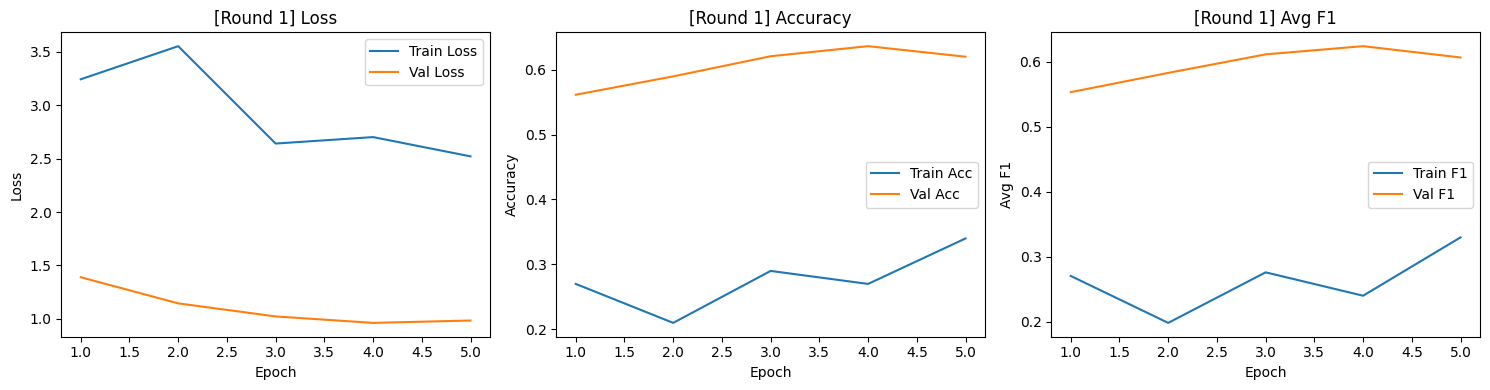


[AL Round 2/5] — Labeled samples: 110


[DEBUG] Dataset size: 15890

Epoch 5/5
Train — Loss: 1.7815 | Acc: 0.5182 | Avg F1: 0.5081
Val   — Loss: 1.3685 | Acc: 0.5952 | Avg F1: 0.5799


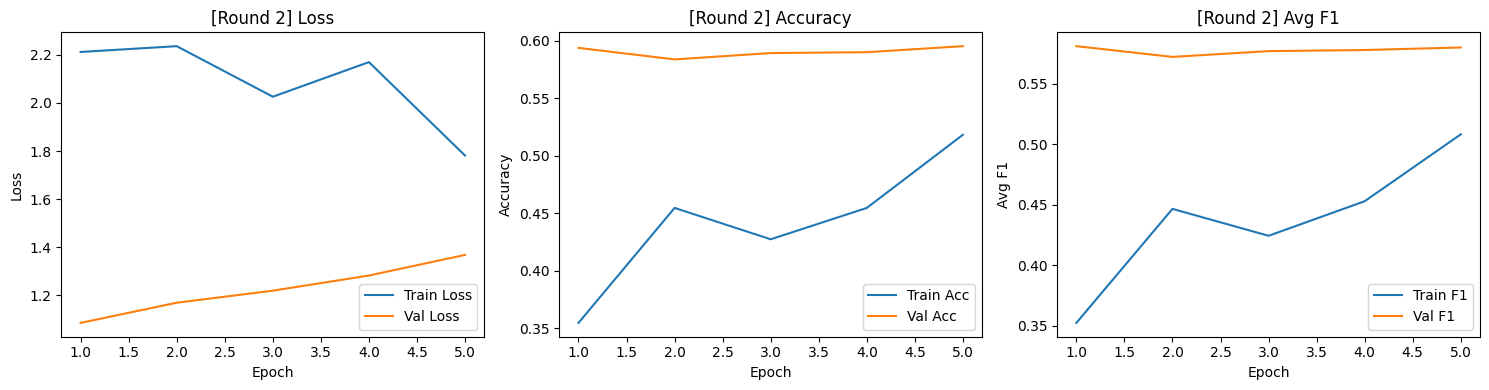


[AL Round 3/5] — Labeled samples: 120


[DEBUG] Dataset size: 15880

Epoch 5/5
Train — Loss: 1.3194 | Acc: 0.5833 | Avg F1: 0.5673
Val   — Loss: 2.4154 | Acc: 0.5555 | Avg F1: 0.5179


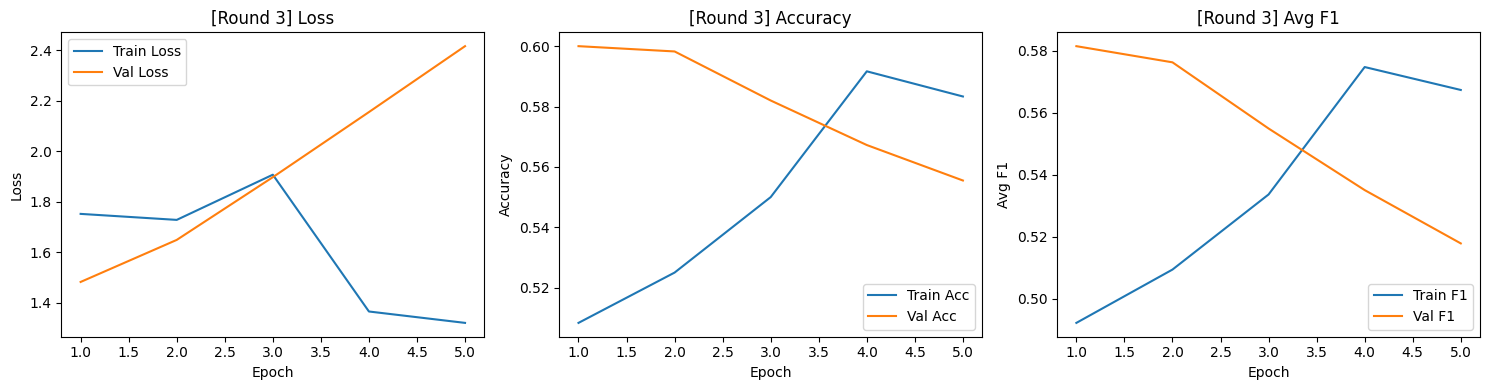


[AL Round 4/5] — Labeled samples: 130


[DEBUG] Dataset size: 15870

Epoch 5/5
Train — Loss: 1.2079 | Acc: 0.5615 | Avg F1: 0.5362
Val   — Loss: 2.8957 | Acc: 0.5833 | Avg F1: 0.5367


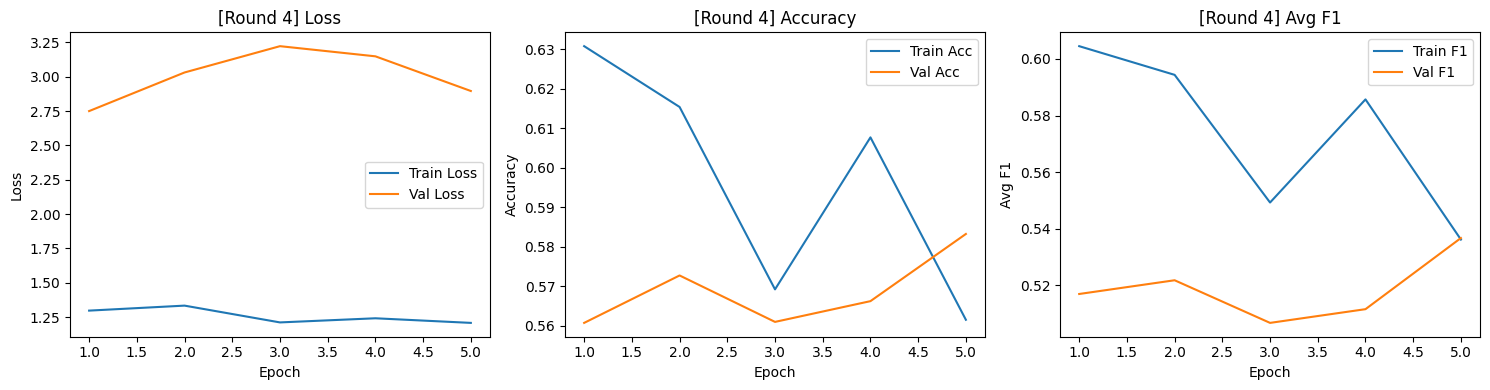


[AL Round 5/5] — Labeled samples: 140


[DEBUG] Dataset size: 15860

Epoch 10/10
Train — Loss: 1.1007 | Acc: 0.7429 | Avg F1: 0.7073
Val   — Loss: 1.7833 | Acc: 0.7310 | Avg F1: 0.7139


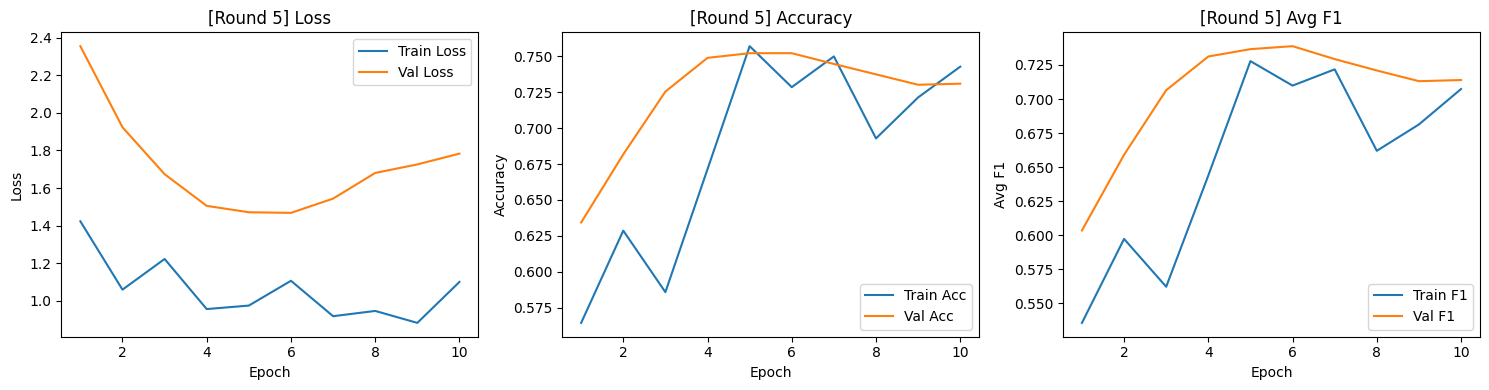

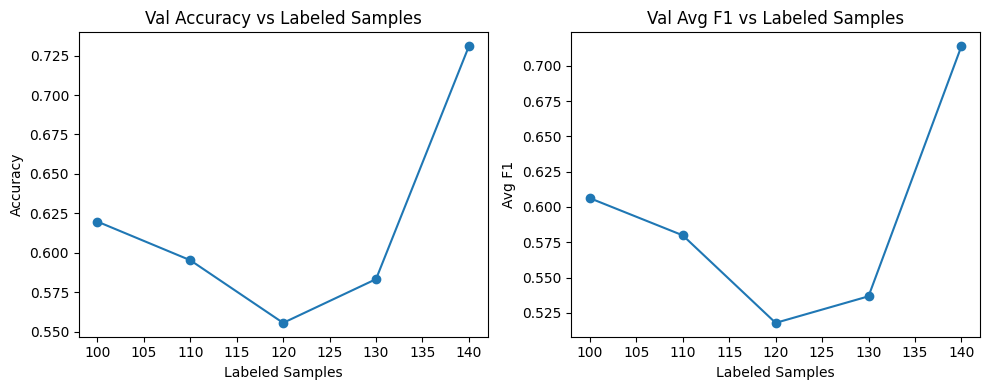


=== Running strategy: LEAST_COUNT ===

[AL Round 1/5] — Labeled samples: 100


[DEBUG] Dataset size: 15900


ValueError: need at least one array to concatenate

In [15]:
all_histories = {}

for initial_labeled, iters,query_size in data:
    initial_labeled= 1-initial_labeled/len(X_pool)
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_pool, y_pool, test_size=initial_labeled, stratify=y_pool, random_state=42)
    print(f"X_labeled shape: {X_labeled.shape}")
    print(f"y_labeled shape: {y_labeled.shape}")
    print(f"X_unlabeled shape: {X_unlabeled.shape}")
    print(f"y_unlabeled shape: {y_unlabeled.shape}")
    
    
    labeled_dataset = Dataset(X_labeled, y_labeled)
    unlabeled_dataset = Dataset(X_unlabeled, y_unlabeled)
    val_dataset = Dataset(X_val, y_val)
    
    for strat in strategies:
        print(f"\n=== Running strategy: {strat.upper()} ===")
        
        # Reset datasets to initial versions (deepcopy to avoid mutations)
        labeled = copy.deepcopy(labeled_dataset)
        unlabeled = copy.deepcopy(unlabeled_dataset)
    
        model.load_state_dict(copy.deepcopy(initial_state_dict))
        
        hist = active_learning_loop(
            model,
            labeled_dataset=labeled,
            unlabeled_dataset=unlabeled,
            val_dataset=val_dataset,
            strategy=strat,
            device=device,
            iters=iters,
            query_size=query_size,
            final_epochs=15,
            loss_mode=loss_mode
        )
        
        all_histories[(strat, initial_labeled, iters, query_size)] = hist


with open("/kaggle/working/history_entropy.pkl", "wb") as f:
    pickle.dump(all_histories, f)

# Plotting final result

In [ ]:
#figuring out different data sizes

def eff_total_labeled_samples(init, iterations, query):
    return round(iterations * init + query * (iterations * (iterations - 1)) // 2)

def total_labeled_samples(init, iterations, query):
    return init+query*iterations

def best_cumsum(available):
    best = (0, 0, 0, 0)  # (cumsum, init, step, n)
    for init in range(1, available + 1):
        for step in range(1, available + 1):
            # max possible n for this init and step
            max_n = (available - init) // step
            for n in range(1, max_n + 1):
                total = init + n * step
                if total <= available:
                    cumsum = n * init + step * n * (n - 1) // 2
                    if cumsum > best[0]:
                        best = (cumsum, init, step, n)
    return best

available = 100
cumsum, init, step, n = best_cumsum(available)
print(f"Max cumsum = {cumsum} with init={init}, step={step}, n={n}")


example = [ (30,20,1), (60,40,1),(120,40,2),(120,80,1),(180,40,3),(300,40,5) ]

for init,iterations,query in example:
    print(f'Init: {init}, Iters: {iterations}, Query: {query}, Total: {total_labeled_samples(init, iterations, query)}, Effective: {eff_total_labeled_samples(init, iterations, query)}')

In [ ]:
def eff_total_labeled_samples(init, iterations, query):
    return round(iterations * init + query * (iterations * (iterations - 1)) // 2)

def total_labeled_samples(init, iterations, query):
    return init+query*iterations

unique_configs = sorted(set((init_size, iters, query) for (_, init_size, iters, query) in all_histories.keys()))

for init_size, iters, query in unique_configs:
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"Init: {round(len(X_pool)*(1-init_size))}, Iters: {iters}, Query: {query}, Samples Used: {total_labeled_samples(round(len(X_pool)*(1-init_size)), iters, query)}, Eff Samples: {eff_total_labeled_samples(round(len(X_pool)*(1-init_size)), iters, query)}", fontsize=14)
    # Accuracy
    plt.subplot(1, 2, 1)
    for (strat, size, iters_, query_), hist in all_histories.items():
        if (size, iters_, query_) == (init_size, iters, query):
            plt.plot(hist["samples"], hist["round_val_acc"], label=strat, marker='o')
            # Show final accuracy value
            x_final = hist["samples"][-1]
            y_final = hist["round_val_acc"][-1]
            plt.text(x_final, y_final, f"{y_final:.3f}", fontsize=8, ha='right', va='bottom')
    plt.title("Validation Accuracy")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Accuracy")
    plt.legend()

    # F1 Score
    plt.subplot(1, 2, 2)
    for (strat, size, iters_, query_), hist in all_histories.items():
        if (size, iters_, query_) == (init_size, iters, query):
            plt.plot(hist["samples"], hist["round_val_avg_f1"], label=strat, marker='o')
            # Show final F1 value
            x_final = hist["samples"][-1]
            y_final = hist["round_val_avg_f1"][-1]
            plt.text(x_final, y_final, f"{y_final:.3f}", fontsize=8, ha='right', va='bottom')
    plt.title("Validation Avg F1")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Avg F1 Score")
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
import csv
import os

# Create export directory
export_dir = "active_learning_results"
os.makedirs(export_dir, exist_ok=True)

# Combined CSV file
all_csv_path = os.path.join(export_dir, "all_results.csv")
with open(all_csv_path, mode="w", newline='') as all_csv_file:
    writer_all = csv.writer(all_csv_file)
    writer_all.writerow(["strategy", "init", "iterations", "query", "sample_size", "accuracy", "f1_score"])
    print("strategy,init,iterations,query,sample_size,accuracy,f1_score")  # Header for print

    for init_size, iters, query in unique_configs:
        init_abs = round(len(X_pool) * (1 - init_size))
        filename = f"results_init{init_abs}_iters{iters}_query{query}.csv"
        filepath = os.path.join(export_dir, filename)

        with open(filepath, mode="w", newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["strategy", "init", "iterations", "query", "sample_size", "accuracy", "f1_score"])

            for (strat, size, iters_, query_), hist in all_histories.items():
                if (size, iters_, query_) == (init_size, iters, query):
                    for s, acc, f1 in zip(hist["samples"], hist["round_val_acc"], hist["round_val_avg_f1"]):
                        row = [strat, init_abs, iters, query, s, round(acc, 6), round(f1, 6)]
                        print(",".join(map(str, row)))   # Print CSV-style row
                        writer.writerow(row)
                        writer_all.writerow(row)

print(f"\n✅ All results exported to directory: {export_dir}")
